In [1]:
%load_ext autoreload
%autoreload 2

This combines the details from the previous attempts at featurizing the lemmas and puts them into the featurizer.py library.

The main strategy for featurization of clauses is given in the file.  The main theme is to use the tags, and to use types in place of the variable.

The featurization is to use the entire state tokens.  This experiment examines strict unigram overlap between lemma queries and matching ones in the theory bank.  As the overlap shows, separation isn't all that great between the requested lemma and the entire state.

In [2]:
import collections
from collections import Counter
from pprint import pprint
from tqdm import tqdm
import pandas as pd
from pathlib import Path
from pprint import pprint
from sklearn.model_selection import train_test_split
from IPython.display import JSON
from tqdm import tqdm
import json

from coprover import PROJ_ROOT, RSC_ROOT, PVSLIB_ROOT

from featurizer import *

DATA_ROOT = Path(PROJ_ROOT, "data", "pvs", "pvslib")
json_files = list(DATA_ROOT.rglob("*.json"))

In [3]:
theory_files = list(DATA_ROOT.glob("*/*.json"))
proof_files = list(DATA_ROOT.glob("*/*/*.json"))
print(len(theory_files), len(proof_files))

615 9216


In [82]:
class TheoryBank:
    def __init__(self, theory_files):
        self.all_theories = collections.OrderedDict()
        self.all_lemmas = collections.OrderedDict()
        for json_fpath in tqdm(theory_files):
            with open(json_fpath, 'r') as f:
                theory_name = json_fpath.stem
                doc_root = json.load(f)
                theory = read_theory(doc_root)
                self.all_theories[theory_name] = theory
                self.all_lemmas.update(theory)
    
    def get(self, name, theories=None):
        if theories is None:
            theories = sorted(self.all_theories.keys())
        for theory in theories:
            if name in self.all_theories[theory]:
                return self.all_theories[theory][name], theory
        return None, None
        # raise Exception("Could not identify name={} in theory set={}".format(name, theories))
    
    def sample(self, rand_obj=None):
        if rand_obj is None:
            return np.random.choice(list(self.all_lemmas.values()))
        else:
            return rand_obj.choice(list(self.all_lemmas.values()))

In [83]:
theory_bank = TheoryBank(theory_files)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 615/615 [00:01<00:00, 328.53it/s]


In [86]:
list(theory_bank.all_lemmas.keys())[0:3]

['imp_derivatives_tcc1', 'imp_derivatives_tcc2', 'dot_prod_derivable']

In [88]:
theory_bank.get("imp_derivatives_tcc2")

(['constantName', 'deriv_domain_def__not_one_elementp'], 'deriv_dot_prod')

In [89]:
theory_bank.sample()

/tmp/ipykernel_48401/2395595031.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.random.choice(list(self.all_lemmas.values()))


['bindings',
 'variableName',
 'x',
 'expression',
 'operator',
 'relations_extra__linear_orderp',
 'constantName',
 'relations_extra__linear_orderp',
 'argument',
 'variableName',
 'x']

In [68]:
x = list(theory_bank.all_theories.keys())
x[0]

'deriv_dot_prod'

In [8]:
sa_tuples = read_proof_session_lemmas(Path(PROJ_ROOT, "data/pvs/pvslib/algebra/ring_with_one_prime_ideal-proofs/prime_ideal_charac.json"))
for sa_tuple in sa_tuples:
    cmd, arg = sa_tuple[1], sa_tuple[2]
    if arg is not None and isinstance(arg, str):
        arg = arg.split("[")[0]
        if cmd in set(["lemma", "rewrite"]):
            expr, theory = theory_bank.get(arg)
            print(cmd, arg, expr, theory)

lemma commutative_quotient_ring None None
rewrite commutative_quotient_ring None None
lemma prime_ideal_nz_closed ['bindings', 'variableName', 'p', 'variableName', 'r', 'expression', 'operator', 'booleans__IMPLIES', 'constantName', 'booleans__IMPLIES', 'argument', 'operator', 'booleans__AND', 'constantName', 'booleans__AND', 'argument', 'operator', 'ring_def__commutative_ringp', 'constantName', 'ring_def__commutative_ringp', 'argument', 'variableName', 'r', 'operator', 'ring_prime_ideal_def__prime_idealp', 'constantName', 'ring_prime_ideal_def__prime_idealp', 'argument', 'variableName', 'p', 'variableName', 'r', 'operator', 'ring_nz_closed_def__nz_closedp', 'constantName', 'ring_nz_closed_def__nz_closedp', 'argument', 'operator', 'restrict__restrict', 'constantName', 'restrict__restrict', 'argument', 'operator', 'cosets_def__divide', 'constantName', 'cosets_def__divide', 'argument', 'variableName', 'r', 'variableName', 'p'] ring_with_one_prime_ideal
rewrite prime_ideal_nz_closed ['bind

In [26]:
# Now go through each of the proofs and collect the lemma requests

LEMMA_OUTPUT_FPATH = Path("lemma_requests.json")
NAME = "name"
STEP = "step"
STATE = "state"
CMD = "command"
ARGS = "args"

if LEMMA_OUTPUT_FPATH.exists():
    # Load the lemma queries
    print("Lemma queries cached, loading")
    with open(LEMMA_OUTPUT_FPATH, 'r') as f:
        lemma_requests = json.load(f)
else:
    # Accumulate the lemma retrieval queries
    tqdm_iter = tqdm(proof_files)
    num_lemma_requests = 0
    lemma_requests = []


    for json_fpath in tqdm_iter:
        name = Path(json_fpath).stem
        sa_tuples = read_proof_session_lemmas(json_fpath)
        if sa_tuples is None:
            continue
        for step_num, sa_tuple in enumerate(sa_tuples):
            cmd, arg = sa_tuple[1], sa_tuple[2]
            if arg is not None and isinstance(arg, str):
                arg = arg.split("[")[0]
                if cmd in set(["lemma", "rewrite"]):
                    # expr, theory = theory_bank.get(arg)
                    num_lemma_requests += 1
                    lemma_requests.append({
                        STATE:  sa_tuple[0],
                        CMD: cmd,
                        ARGS: arg,
                        NAME: name,
                        STEP: step_num
                    })
                    tqdm_iter.set_description("# lemma requests={}".format(num_lemma_requests))

    # Save out the accumulated lemma requests to file                
    with open(LEMMA_OUTPUT_FPATH, 'w') as f:
        json.dump(lemma_requests, f)

Lemma queries cached, loading


In [33]:
import numpy as np
import collections


In [35]:
num_missing = 0
total_scanned = len(lemma_requests)
missing_lemmas = collections.Counter()
for req in tqdm(lemma_requests):
    lemma_name = req[ARGS]
    lemma, theory = theory_bank.get(lemma_name)
    if lemma is None:
        missing_lemmas[lemma_name] += 1
        num_missing += 1
print("Total missing = {}/{}".format(num_missing, total_scanned))

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 20221/20221 [00:04<00:00, 4903.62it/s]

Total missing = 7016/20221


In [118]:
len(missing_lemmas)

895

In [122]:
for x in list(missing_lemmas)[0:20]: print(x)

not_one_element2
zero_times
emptyset_is_empty?
infinite_nonempty
one_in
epsilon_ax
connected_domain
C_n_plus_1
every_nth
card_below
sigma_shift_T
Integral_split
naturalnumbers.nat_induction
multiary_Heine
zero_times3
triangle
composition_injective
even_times_int_is_even
countable_is_null
cos_neg


In [128]:
def characterize1(state):
    feats = collections.Counter(state)
    return feats

def overlap1(state1, state2):
    intersect = characterize1(state1) & characterize1(state2) 
#    return np.sum(list(intersect.values())) 
    return np.sum(list(intersect.values())) / len(state1)

def scan(X):
    mu, std, xmin, xmax = np.mean(X), np.std(X), np.min(X), np.max(X)
    return "mu/std={:.3f}/{:.3f}, min/max={:.3f}/{:.3f}".format(mu, std, xmin, xmax)

  0%|                                                                                                              | 0/20221 [00:00<?, ?it/s]/tmp/ipykernel_48401/2395595031.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.random.choice(list(self.all_lemmas.values()))
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 20221/20221 [00:44<00:00, 454.75it/s]


Overlap stats, matched: mu/std=20.512/14.415, min/max=0.000/157.000
Background stats: mu/std=16.498/15.014, min/max=0.000/259.000


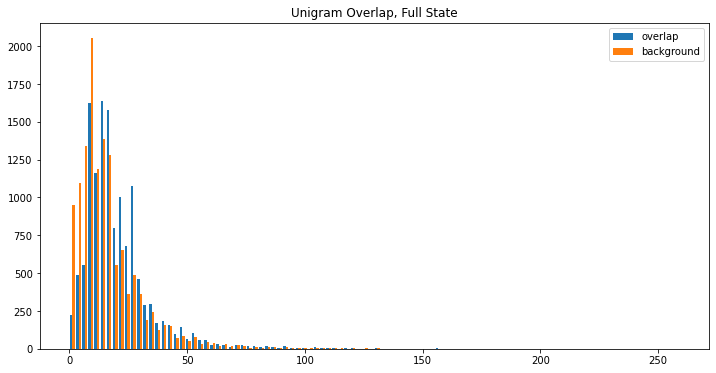

In [126]:
# Now for the lemmas, identify the overlap between the features and the retrieved lemma
num_missing = 0
total_scanned = len(lemma_requests)
missing_lemmas = collections.Counter()
overlap_scores = []
background_scores = []
for req in tqdm(lemma_requests):
    lemma_name = req[ARGS]
    state = req[STATE]
    lemma, theory = theory_bank.get(lemma_name)
    if lemma is None:
        missing_lemmas[lemma_name] += 1
        num_missing += 1
    else:
        # Do some simple token overlap measures
        overlap_scores.append(overlap1(state, lemma))
        # Get background sample
        background_scores.append(overlap1(state, theory_bank.sample()))
        
print("Overlap stats, matched: {}".format(scan(overlap_scores)))
print("Background stats: {}".format(scan(background_scores)))

# Get matches between entire state and the theory bank

from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(12,6))
ax.hist([overlap_scores, background_scores], label=["overlap", "background"], bins=100)
plt.title("Unigram Overlap, Full State")
plt.legend()

We now and examine just the goal statements

  0%|                                                                                                              | 0/20221 [00:00<?, ?it/s]/tmp/ipykernel_48401/2395595031.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.random.choice(list(self.all_lemmas.values()))
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 20221/20221 [00:44<00:00, 450.06it/s]


Overlap stats, matched: mu/std=18.069/13.721, min/max=0.000/127.000
Background stats: mu/std=14.632/14.086, min/max=0.000/202.000


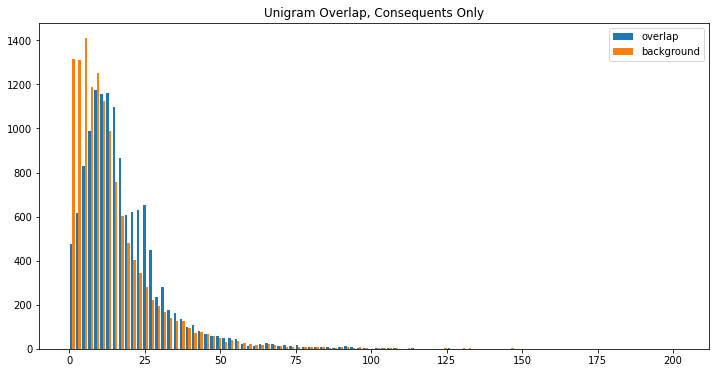

In [127]:
# Now for the lemmas, identify the overlap between the features and the retrieved lemma
def collect_consequents(state):
    collecting = False
    goal_toks = []
    for token in state:
        if token == "consequents":
            collecting = True
        elif collecting:
            goal_toks.append(token)
    return goal_toks

num_missing = 0
total_scanned = len(lemma_requests)
missing_lemmas = collections.Counter()
overlap_scores = []
background_scores = []
for req in tqdm(lemma_requests):
    lemma_name = req[ARGS]
    state = collect_consequents(req[STATE])
    assert(len(state) > 0)
    lemma, theory = theory_bank.get(lemma_name)
    if lemma is None:
        missing_lemmas[lemma_name] += 1
        num_missing += 1
    else:
        # Do some simple token overlap measures
        overlap_scores.append(overlap1(state, lemma))
        # Get background sample
        background_scores.append(overlap1(state, theory_bank.sample()))
        
print("Overlap stats, matched: {}".format(scan(overlap_scores)))
print("Background stats: {}".format(scan(background_scores)))

from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(12,6))
ax.hist([overlap_scores, background_scores], label=["query", "background"], bins=100)
plt.title("Unigram Overlap, Consequents Only")
plt.legend()

  0%|                                                                                                              | 0/20221 [00:00<?, ?it/s]/tmp/ipykernel_48401/2395595031.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.random.choice(list(self.all_lemmas.values()))
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 20221/20221 [00:44<00:00, 453.37it/s]


Overlap stats, matched: mu/std=0.249/0.186, min/max=0.000/0.850
Background stats: mu/std=0.198/0.158, min/max=0.000/0.774


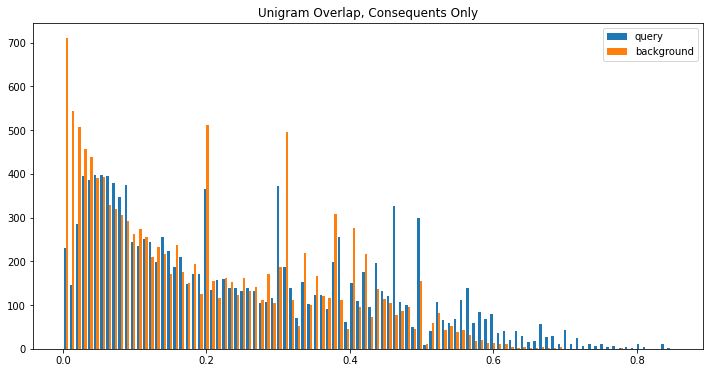

In [130]:
# Now for the lemmas, identify the overlap between the features and the retrieved lemma
def collect_consequents(state):
    collecting = False
    goal_toks = []
    for token in state:
        if token == "consequents":
            collecting = True
        elif collecting:
            goal_toks.append(token)
    return goal_toks

num_missing = 0
total_scanned = len(lemma_requests)
missing_lemmas = collections.Counter()
overlap_scores = []
background_scores = []
for req in tqdm(lemma_requests):
    lemma_name = req[ARGS]
    state = collect_consequents(req[STATE])
    assert(len(state) > 0)
    lemma, theory = theory_bank.get(lemma_name)
    if lemma is None:
        missing_lemmas[lemma_name] += 1
        num_missing += 1
    else:
        # Do some simple token overlap measures
        overlap_scores.append(overlap1(state, lemma))
        # Get background sample
        background_scores.append(overlap1(state, theory_bank.sample()))
        
print("Overlap stats, matched: {}".format(scan(overlap_scores)))
print("Background stats: {}".format(scan(background_scores)))

from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(12,6))
ax.hist([overlap_scores, background_scores], label=["query", "background"], bins=100)
plt.title("Unigram Overlap, Consequents Only")
plt.legend()